<a href="https://colab.research.google.com/github/aguilin1/tda_ai_text_generation/blob/main/eli_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-tda

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 19.3 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=d3f0e8571b371768cafba53efb4988cffa84731fe735bb9a05521892cc5a94d1
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


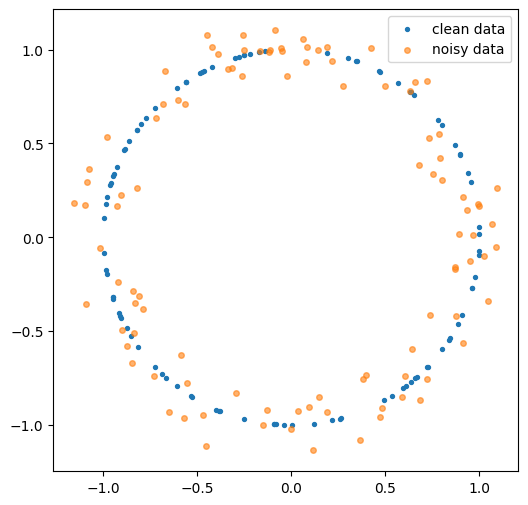

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import tadasets
np.random.seed(565656)

data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.10)

# data_clean = tadasets.infty_sign(n=100, noise=0.0)
# data_noisy = tadasets.infty_sign(n=100, noise=0.15)

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data", s=16, alpha=0.6)
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
# Making the distance matrix
# Functions ---
# cosSimDistanceMatrix: creates cosine similarity distance matrix
# vrFiltration: takes a distance matrix and computes Vietoris-Rips filtration

from sklearn.metrics.pairwise import cosine_similarity
import itertools

def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  dist = 2 * np.arccos(cos_sim) / np.pi
  return dist

# input a single array of embeddings
def angular_distance_matrix(embeddings):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances


def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
    distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
    dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances

# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=2):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

def load_cached_embeddings(abstract_type, embedding_type):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, 1)
  bow_data = DATA_FILE_BASE.format('bow', abstract_type, 0)


  if embedding_type == 'bert':
    with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  elif embedding_type == 'bow':
    with open(bow_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  return batch_sentences, batch_embeddings


def run_evaluation(abstract_type, embedding_type):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type)

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,6))
  plt.title("Persistence diagram for {} text encoded with {}".format(abstract_type, embedding_type.upper()))
  subplot = 1
  for i, embeddings in enumerate(batch_embeddings[0:6]):
    distances = angular_distance_matrix(embeddings)
    # let's just call
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(2,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()


def run_mixed_encoding_evaluation(abstract_type, alpha, n):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow')
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert')
  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,6))
  plt.title("Persistence diagram for {} mixed encoding with alpha={}".format(abstract_type, alpha))
  subplot = 1
  for i in range(n):
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha)
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(2,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()
  return bert_diagrams, distances

run_evaluation('ai', 'bow')

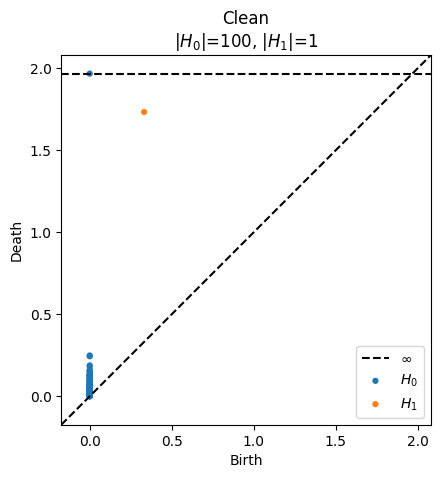

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


ValueError: Distance matrix is not square

In [18]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])
dgm_clean = ripser.ripser(data_clean)['dgms']
persim.plot_diagrams(
    dgm_clean,
    show=True,
    title=f"Clean\n{diagram_sizes(dgm_clean)}"
)

from ripser import Rips
rips = Rips()
dgm_noisy = rips.transform(distances, distance_matrix=True)
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm_noisy)}")

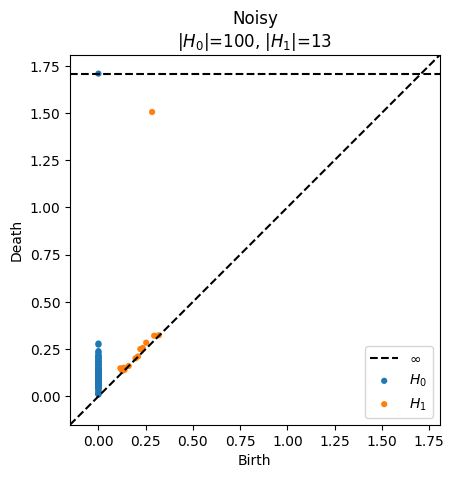

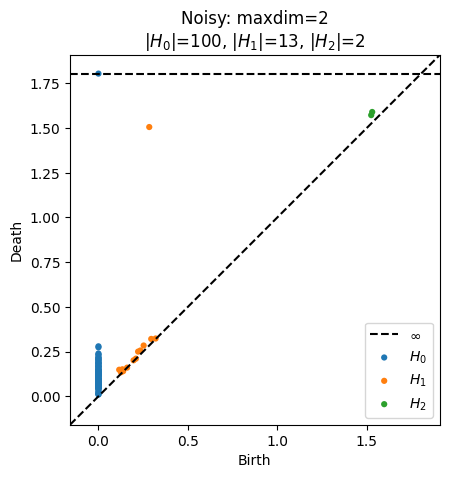

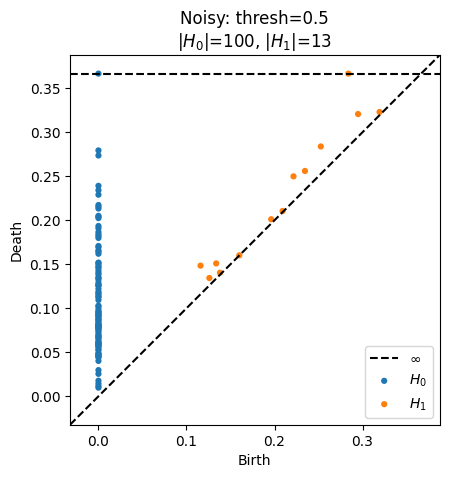

In [11]:
from sklearn.metrics.pairwise import pairwise_distances

D = pairwise_distances(data_noisy, metric='euclidean')

dgm_noisy = ripser.ripser(D, distance_matrix=True)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True,
    title=f"Noisy\n{diagram_sizes(dgm_noisy)}"
)
dgm_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True,
    title=f"Noisy: maxdim=2\n{diagram_sizes(dgm_noisy)}"
)
thresh = 0.5
dgm_noisy = ripser.ripser(data_noisy, thresh=thresh)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True,
    title=f"Noisy: thresh={thresh}\n{diagram_sizes(dgm_noisy)}"
)

<ipython-input-14-97b9c5ae6207>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab10')


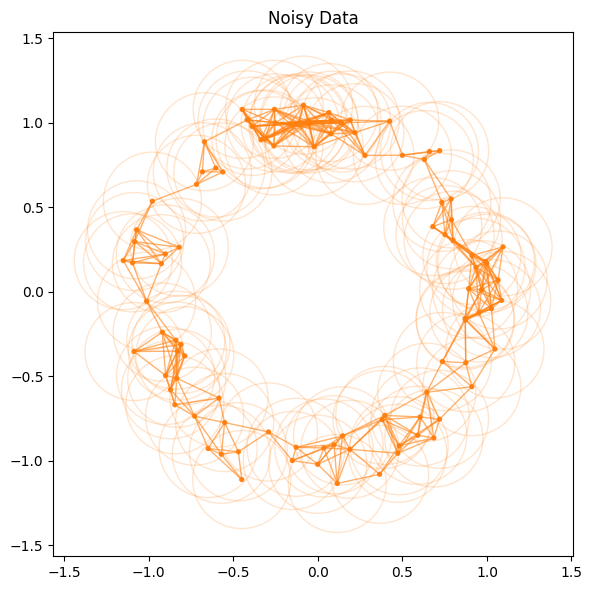

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


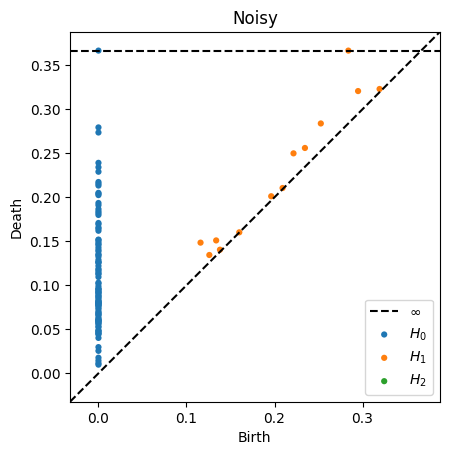

In [14]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def plot_rips_complex(data, R, label="data", col=1, maxdim=2):
    tab10 = cm.get_cmap('tab10')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(label)
    ax.scatter(
        data[:, 0], data[:, 1], label=label,
        s=8, alpha=0.9, c=np.array(tab10([col] * len(data)))
    )

    for xy in data:
        ax.add_patch(mpatches.Circle(xy, radius=R, fc='none', ec=tab10(col), alpha=0.2))

    for i, xy in enumerate(data):
        if maxdim >=1:
            for j in range(i + 1, len(data)):
                pq = data[j]
                if (xy != pq).all() and (np.linalg.norm(xy - pq) <= R):
                    pts = np.array([xy, pq])
                    ax.plot(pts[:, 0], pts[:, 1], color=tab10(col), alpha=0.6, linewidth=1)
                if maxdim == 2:
                    for k in range(j + 1, len(data)):
                        ab = data[k]
                        if ((ab != pq).all()
                                and (np.linalg.norm(xy - pq) <= R)
                                and (np.linalg.norm(xy - ab) <= R)
                                and (np.linalg.norm(pq - ab) <= R)
                        ):
                            pts = np.array([xy, pq, ab])
                            ax.fill(pts[:, 0], pts[:, 1], facecolor=tab10(col), alpha=0.1)
                        pass

    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    pass

plot_rips_complex(data_noisy, R=0.29, label="Noisy Data", maxdim=1)

#1.2.3
rips = Rips()
rips.maxdim = 2
rips.thresh = 0.5
rips.coef = 3
rips.transform(data_noisy)
rips.plot(show=True, title='Noisy')

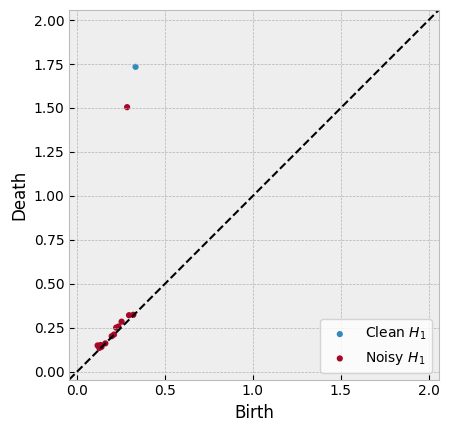

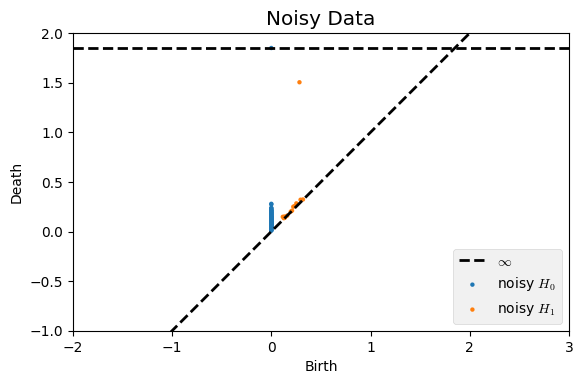

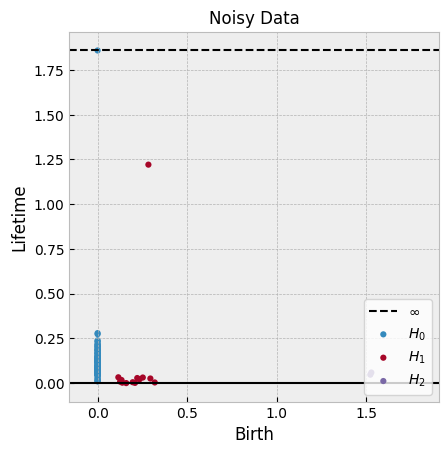

In [16]:
dgms_clean = ripser.ripser(data_clean)['dgms']
dgms_noisy = ripser.ripser(data_noisy, maxdim=2)['dgms']
persim.plot_diagrams(
    [dgms_clean[1], dgms_noisy[1]],
    labels=['Clean $H_1$', 'Noisy $H_1$'],
    show=True
)

#1.3.2
persim.plot_diagrams(
    dgms_noisy,
    title="Noisy Data",
    labels=["noisy $H_0$", "noisy $H_1$"],
    colormap="bmh",
    xy_range=[-2,3, -1, 2],
    size=10,
    diagonal=True,
    show=True
)

#1.3.3
persim.plot_diagrams(
    dgms_noisy,
    title="Noisy Data",
    lifetime=True,
    show=True
)

<Axes: title={'center': 'Persistence Image'}, xlabel='birth', ylabel='persistence'>

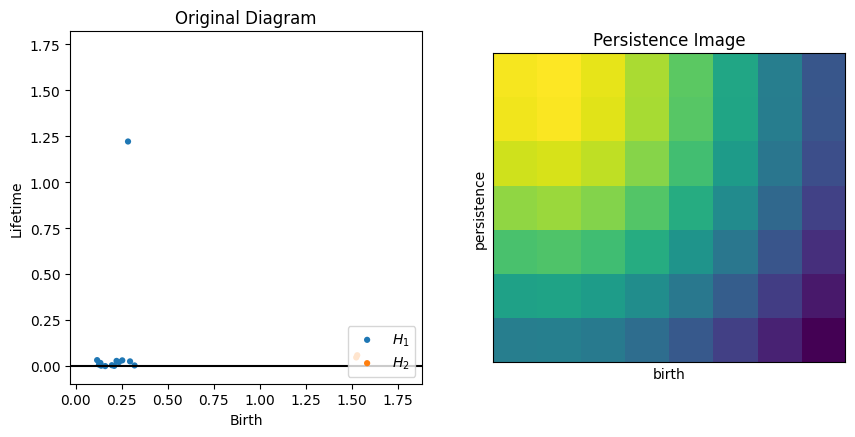

In [17]:
from persim import PersistenceImager

pimager = PersistenceImager(pixel_size=0.2)

# The `fit()` method can be called on one or more (*,2) numpy arrays
# to automatically determine the miniumum birth and persistence ranges needed to capture all persistence pairs.
# The ranges and resolution are automatically adjusted to accomodate the specified pixel size.
pimager.fit(dgms_noisy[1:3])

# The `transform()` method can then be called on one or more (*,2) numpy arrays
# to generate persistence images from diagrams.
imgs = pimager.transform(dgms_noisy[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].set_title("Original Diagram")
persim.plot_diagrams(dgms_noisy[1:3],  lifetime=True, ax=axs[0], labels=["$H_1$", "$H_2$"])

axs[1].set_title("Persistence Image")
pimager.plot_image(imgs[0], ax=axs[1])